# Импорт библиотек

In [5]:
!pip install pydicom

   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ----------------- ---------------------- 1.0/2.4 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 13.6 MB/s eta 0:00:00


In [427]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Загрузка данных

In [37]:
def read_dicom(path):
    """
    Читает DICOM файл и конвертирует в numpy array
    """
    dicom = pydicom.dcmread(path)
    data = dicom.pixel_array

    # Исправление инверсии цветов
    data = np.amax(data) - data
    
    # Нормализация
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    return data

def plot_single_dicom(image, title="", figsize=(8, 8)):
    """
    Визуализация одного DICOM изображения
    """
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.title(title, fontweight='bold')
    plt.axis('off')
    plt.show()

In [55]:
# Пути к данным
data_dir = "vinbigdata"  
train_dir = os.path.join(DATA_DIR, "train")
test_dir= os.path.join(DATA_DIR, "test")

# Загрузка метаданных
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))[['image_id', 'class_name', 'class_id', 'rad_id']]
sample_submission = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))

display(train_df)

,image_id,class_name,class_id,rad_id
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10
...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8


# Разведывательный анализ данных

## Пропуски и дубликаты

In [204]:
print(f"Пропущенных значений: {train_df.isna().sum().sum()}")

Пропущенных значений: 0


In [206]:
print(f"Дубликатов: {train_df.duplicated().sum()}")

Дубликатов: 6640


In [208]:
train_df.drop_duplicates(inplace=True)

## Распределение классов

| Class ID | Английское название | Русский перевод |
|----------|---------------------|-----------------|
| 0 | Aortic enlargement | Аневризма аорты |
| 1 | Atelectasis | Ателектаз |
| 2 | Calcification | Кальцификация |
| 3 | Cardiomegaly | Кардиомегалия |
| 4 | Consolidation | Консолидация |
| 5 | ILD | Интерстициальная болезнь легких |
| 6 | Infiltration | Инфильтрация |
| 7 | Lung Opacity | Легочная непрозрачность |
| 8 | Nodule/Mass | Узел/Образование |
| 9 | Other lesion | Другое поражение |
| 10 | Pleural effusion | Плевральный выпот |
| 11 | Pleural thickening | Утолщение плевры |
| 12 | Pneumothorax | Пневмоторакс |
| 13 | Pulmonary fibrosis | Легочный фиброз |
| 14 | No finding | Патологий не выявлено |

**1. Явный дисбаланс**
- Класс "No finding" доминирует (51.93% всех записей)

**2. Самые редкие классы** (<1%):
- Pneumothorax 
- Atelectasis  
- Consolidation
- ILD	

In [277]:
class_records = (train_df.groupby('class_name')['image_id']
               .count()
               .reset_index()
               .sort_values('image_id', ascending=False)
               .rename(columns={'image_id': 'Number of records'}))

class_records['Percentage'] = (class_records['Number of records'] / class_records['Number of records'].sum() * 100).round(2)

display(class_records)

,class_name,Number of records,Percentage
8,No finding,31818,51.93
0,Aortic enlargement,7157,11.68
3,Cardiomegaly,5414,8.84
14,Pulmonary fibrosis,3267,5.33
12,Pleural thickening,3228,5.27
11,Pleural effusion,2105,3.44
7,Lung Opacity,2036,3.32
10,Other lesion,1623,2.65
9,Nodule/Mass,1412,2.30
6,Infiltration,949,1.55


##  Распределение числа классов на изображение

> На половину изображений приходится 1 класс

In [213]:
classes_per_image = train_df.groupby('image_id')['class_name'].nunique()

In [335]:
print(f"Медиана числа классов на изображение: {classes_per_image.median()}")
print(f"\nМаксимальное число классов на изображение: {classes_per_image.max()}")

Медиана числа классов на изображение: 1.0

Максимальное число классов на изображение: 10


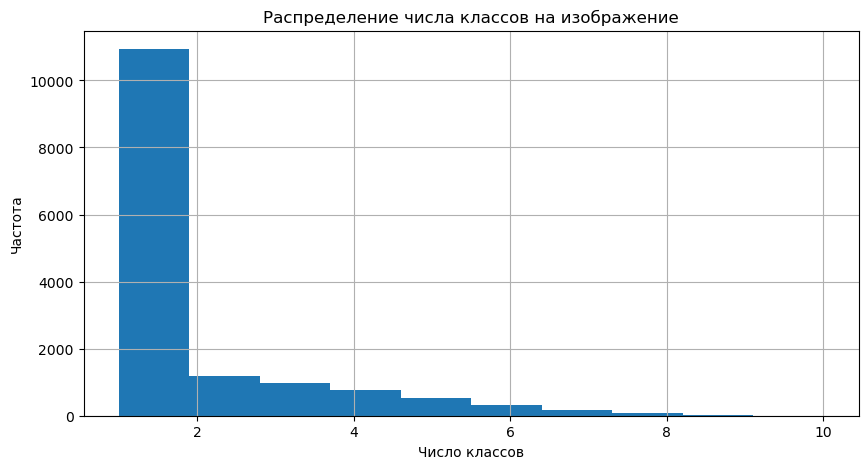

In [361]:
plt.figure(figsize=(10, 5))
classes_per_image.hist(bins=10)
plt.title('Распределение числа классов на изображение')
plt.xlabel('Число классов')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

> Сочетание 'Aortic enlargement' с 'Cardiomegaly' встречается гораздно чаще других 

('Aortic enlargement', 'Cardiomegaly') - 709 изображений
('Aortic enlargement', 'Cardiomegaly', 'Pleural thickening') - 224 изображений
('Aortic enlargement', 'Cardiomegaly', 'Pulmonary fibrosis') - 75 изображений
('Aortic enlargement', 'Pleural thickening') - 69 изображений
('Aortic enlargement', 'Cardiomegaly', 'Other lesion') - 55 изображений
('Aortic enlargement', 'Cardiomegaly', 'Pleural effusion', 'Pleural thickening') - 51 изображений
('Pleural thickening', 'Pulmonary fibrosis') - 50 изображений
('Aortic enlargement', 'Cardiomegaly', 'Pleural thickening', 'Pulmonary fibrosis') - 41 изображений
('Aortic enlargement', 'Cardiomegaly', 'Lung Opacity') - 39 изображений
('Aortic enlargement', 'Pulmonary fibrosis') - 38 изображений


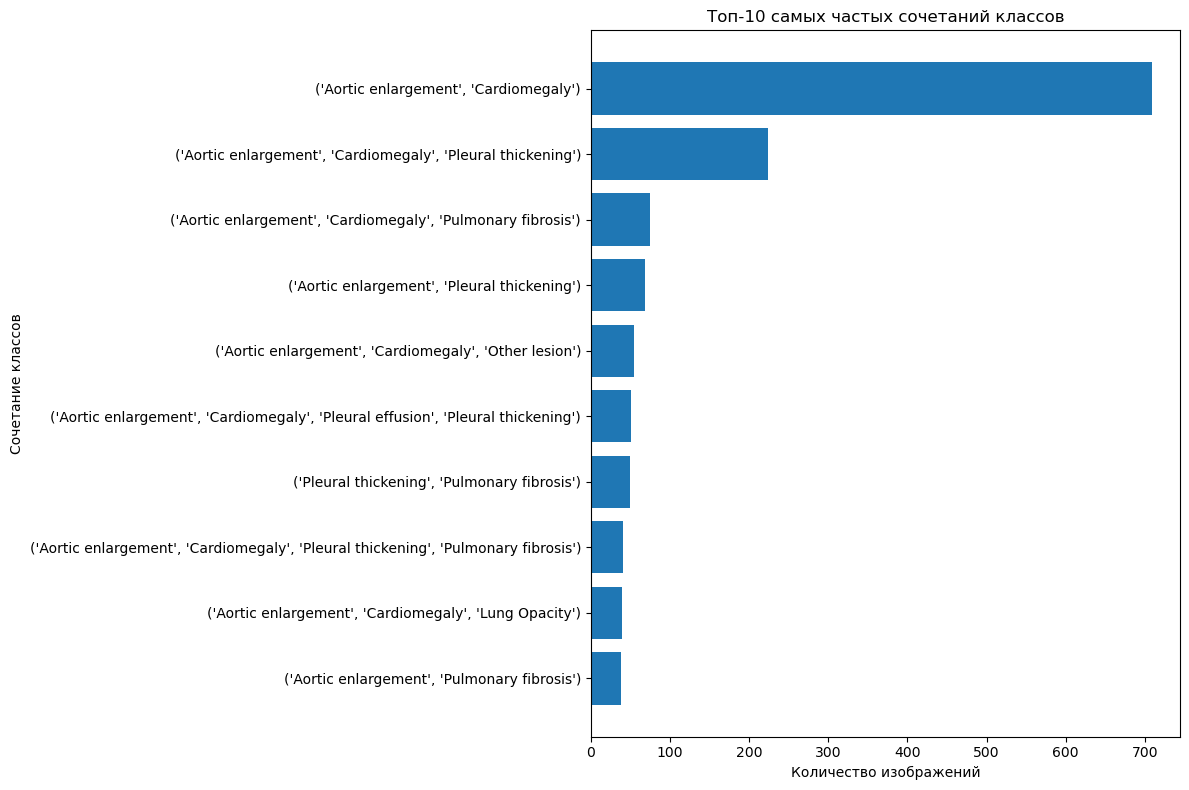

In [279]:
class_combinations = train_df.groupby('image_id')['class_name'].agg(lambda x: tuple(sorted(x.unique())))

class_combination_counts = class_combinations.value_counts().reset_index()
class_combination_counts.columns = ['combination', 'count']
class_combination_counts['num_classes'] = class_combination_counts['combination'].apply(len)
class_combination_counts = class_combination_counts[class_combination_counts['num_classes'] >= 2]

top_class_combinations = class_combination_counts.head(10)
for idx, row in top_class_combinations.iterrows():
    print(f"{row['combination']} - {row['count']} изображений")

plt.figure(figsize=(12, 8))
plt.barh([str(comb) for comb in top_class_combinations['combination']], top_class_combinations['count'])
plt.xlabel('Количество изображений')
plt.ylabel('Сочетание классов')
plt.title('Топ-10 самых частых сочетаний классов')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Распределение разметки радиологов

**Явный дисбаланс**
> 3 радиолога (R9, R10, R8) сделали: **57%** всех разметок 

In [295]:
radiologist_records = train_df.groupby('rad_id')['image_id'].count().sort_values(ascending=False)

In [374]:
radiologist_records

rad_id
R9     12986
R10    11534
R8     10323
R2      3120
R5      2783
R3      2285
R6      2041
R1      1995
R15     1755
R13     1751
R16     1737
R7      1733
R12     1715
R11     1640
R14     1564
R4      1513
R17      799
Name: image_id, dtype: int64

In [401]:
print(f"Данные разметило {len(radiologist_records)} радиологов")
print(f"\n3 радиолога разметило {(12986 + 11534 + 10323) / len(train_df) * 100:.0f}% всех данных")
print(f"\nМедиана разметок на радиолога: {radiologist_records.median()}")
print(f"\nМаксимум разметок на радиолога: {radiologist_records.max()}")
print(f"\nМинимум разметок на радиолога: {radiologist_records.min()}")

Данные разметило 17 радиологов

3 радиолога разметило 57% всех данных

Медиана разметок на радиолога: 1755.0

Максимум разметок на радиолога: 12986

Минимум разметок на радиолога: 799


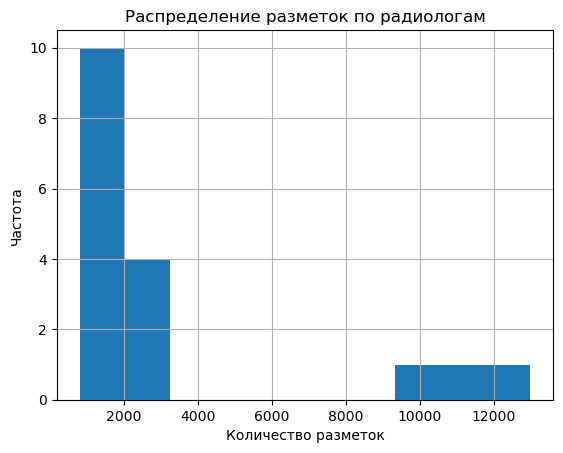

In [365]:
plt.hist(radiologist_records, bins=10)
plt.xlabel('Количество разметок')
plt.ylabel('Частота')
plt.title('Распределение разметок по радиологам')
plt.grid(True)
plt.show()

## Корреляция между классами

In [501]:
class_presence = train_df.pivot_table(
    index='image_id', 
    columns='class_name', 
    values='class_id', 
    aggfunc='count', 
    fill_value=0
)
class_presence = (class_presence > 0).astype(int)

| Классы | Коэффициент корреляции |
|----------|---------------------|
| Cardiomegaly, Aortic enlargement | 0.69 |
| Pleural thickening, Pleural effusion | 0.55 |
| Pleural thickening, Pulmonary fibrosis  | 0.48 |
| Pleural thickening, Aortic enlargement  | 0.46 |
| Lung opacity, Pleural effusion | 0.42 |
| Lung opacity, Consolidation | 0.41 |
| Lung opacity, Pulmonary fibrosis | 0.40 |
| Infiltration, Lung opacity | 0.38 |
| Infiltration, Pulmonary fibrosis| 0.38 |
| Pleural thickening, Lung opacity| 0.37 |

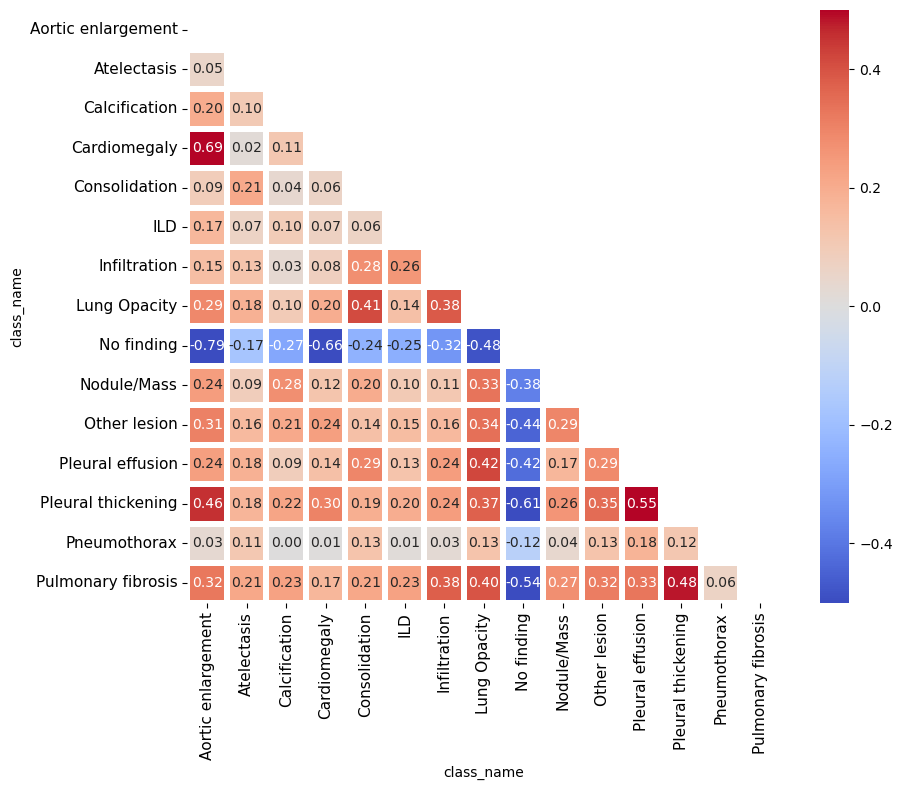

In [485]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

class_corr = class_presence.corr()
mask = np.zeros_like(class_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(class_corr,
            annot=True,
            fmt='.2f',
            square=True,
            mask=mask,
            linewidth=3,
            vmax=0.5, vmin=-0.5,
            cmap=cmap,
            cbar=True,
            ax=ax)

ax.set_yticklabels(ax.get_xticklabels(), rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=11)

plt.tight_layout()
plt.show()